Prepare dataset and download models

In [1]:
!ls ecommerce-behavior-data-from-multi-category-store

2019-Nov.csv  2019-Oct.csv


In [3]:
!mkdir -p imgs && cp /kaggle/input/demo-imgs/* imgs/

In [1]:
!huggingface-cli download bartowski/nvidia_NVIDIA-Nemotron-Nano-9B-v2-GGUF nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf --local-dir . --local-dir-use-symlinks False

/Users/davis/anaconda3/lib/python3.10/site-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
Xet Storage is enabled for this repo. Downloading file from Xet Storage..
nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.g(…): 100%|█| 9.46G/9.46G [23:46<00:00, 6
Download complete. Moving file to nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf
nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf


In [2]:
!ls .

gpu-accelerated-data-science-agent.ipynb
images
LICENSE
nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf
README.md


# GPU-Accelerated Data Science Agent Tutorial

Learn how to build an AI-powered data science agent with GPU acceleration.

## What You'll Learn

- Enable GPU acceleration with NVIDIA cuDF in just 2 lines of code
- Build an AI agent that writes Python code from natural language
- Perform interactive data analysis through conversational AI
- Execute large tabular data operations with GPU acceleration

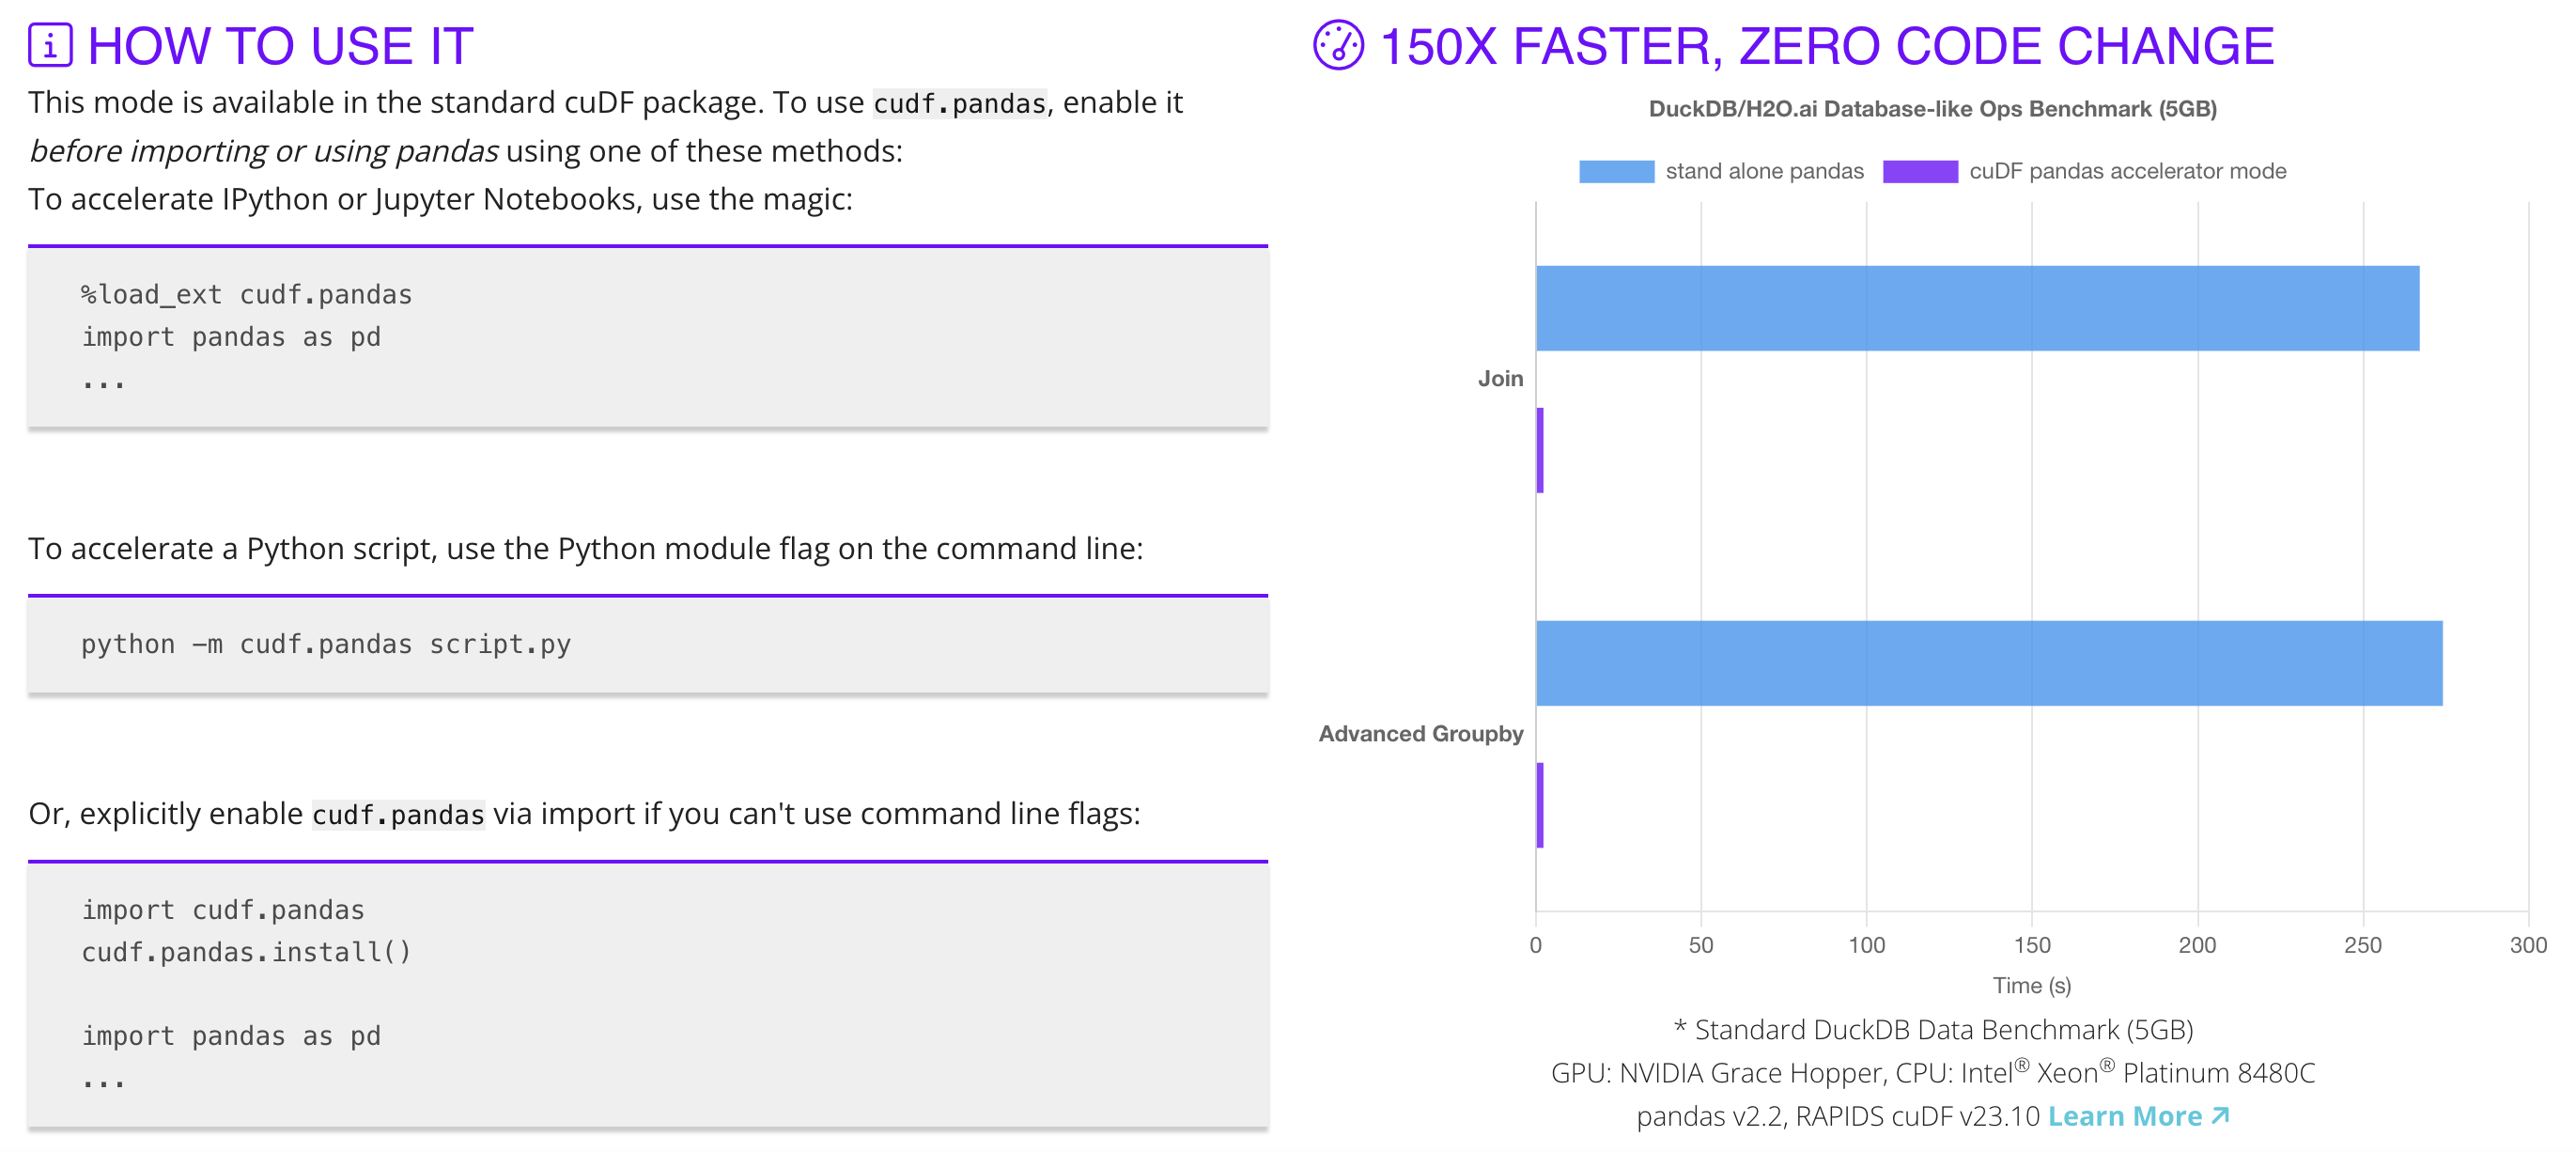

In [7]:
display(Image(filename='imgs/pandas.png'))

## GPU Acceleration in Just 2 Lines of Code

### The Setup

Traditional pandas operations run on CPU. With NVIDIA's `cudf.pandas`, you get massive speedups without changing your code.

```python
import cudf.pandas
cudf.pandas.install()
```

After these two lines, your pandas code automatically runs on GPU when beneficial.

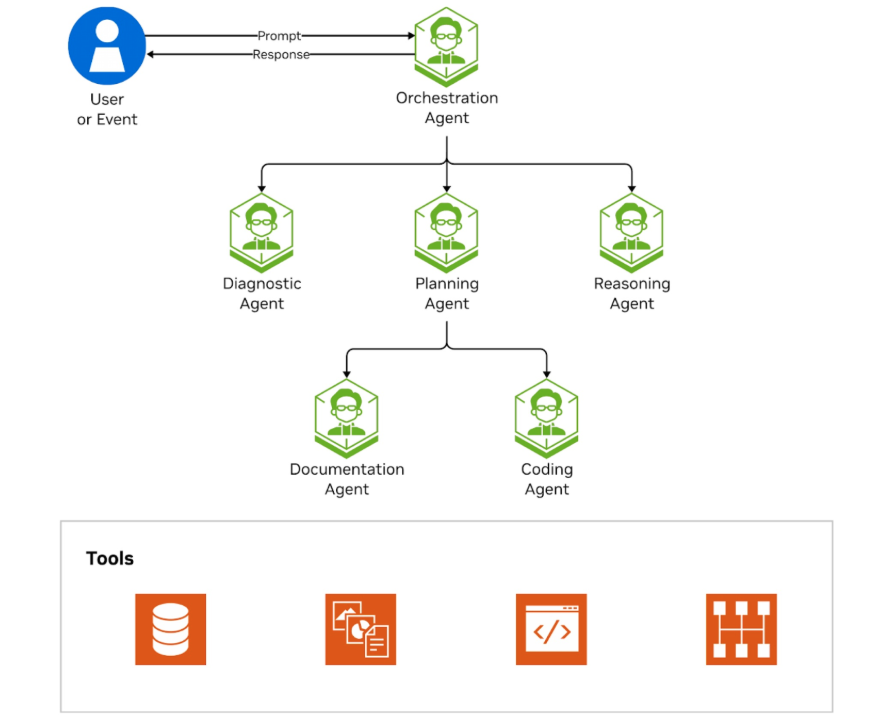

In [3]:
from IPython.display import Image, display
display(Image(filename='images/agentx.png'))

## What is the DataScienceAgent?

The **DataScienceAgent** combines:
- **Large Language Model (LLM)** - Understands natural language requests
- **Function Calling** - Executes Python code dynamically based on questions
- **GPU Acceleration** - Speeds up pandas operations using NVIDIA GPUs

**Key Features:**
- Natural language interface - ask questions in plain English
- GPU-accelerated pandas operations for fast data analysis
- Persistent execution environment - variables carry over between requests
- Smart error recovery - automatically fixes and retries failed code
- Automatic data visualization support

### NVIDIA Nemotron: The Model Behind the Agent

The DataScienceAgent uses **NVIDIA Nemotron-9B-v2**, a language model optimized for:

- Function calling and structured output
- Python code generation and data analysis tasks
- Efficiency - runs locally on consumer GPUs
- Accuracy - competitive with larger models on specific tasks

In [5]:
!cp llamacpp-sm75-complete-build/build/bin/llama-server ./ && chmod +x llama-server

In [6]:
import subprocess
import os

# Set environment variable
env = os.environ.copy()
env['LD_LIBRARY_PATH'] = f"llamacpp-sm75-complete-build/build/bin:{env.get('LD_LIBRARY_PATH', '')}"

# Run the command
process = subprocess.Popen([
    './llama-server',
    '-m', '/kaggle/working/nvidia_NVIDIA-Nemotron-Nano-9B-v2-Q8_0.gguf',
    '--host', '0.0.0.0',
    '--port', '8000',
    '-ngl', '99',
    '--ctx-size', '8192',
    '--n-predict', '2048',
    '--threads', '8',
    '--batch-size', '128',
    '--ubatch-size', '128',
    '--cache-reuse', '256',
    '--flash-attn', 'on',
    '--reasoning-format', 'none', 
    '--chat-template-file', '/kaggle/input/democode/chat-template-no-think.jinja',
    '--jinja'
], env=env)

OSError: [Errno 8] Exec format error: './llama-server'

In [12]:
import time
time.sleep(120) # wait for llm server to come online

## Initialize the Agent

Initialize the DataScienceAgent with the local Nemotron server.

In [13]:
import sys
sys.path.append('/kaggle/input/democode')
from agent import DataScienceAgent
try:
    #agent = DataScienceAgent(verbose=True, force_final_response_after_success=True)
    agent = DataScienceAgent(verbose=True, stream=True, skip_final_response=True)
    print("\nUsing local Nemotron server at http://localhost:8000")
    print("Make sure the server is running with: ./start-nemotron-server.sh\n")
    print("Agent ready! Type your questions in the cells below.\n")
except Exception as e:
    print(f"Error initializing agent: {e}")
    print("\nMake sure the local LLM server is running.")
    print("To use NVIDIA cloud API instead, modify agent initialization in this cell")

[GPU Acceleration] cudf.pandas initialized successfully
DataScienceAgent initialized
  Base URL: http://localhost:8000/v1
  Model: nemotron
  Available tools: ['execute_python_code']


Using local Nemotron server at http://localhost:8000
Make sure the server is running with: ./start-nemotron-server.sh

Agent ready! Type your questions in the cells below.



### How the Agent Works

The agent has the following capabilities:

**Tools Available:**
- `execute_python_code` - Writes and runs pandas code with GPU acceleration

**Intelligence:**
- Understands natural language questions about data
- Automatically generates appropriate pandas code with GPU acceleration
- Handles errors gracefully and retries with corrections
- Remembers context across the conversation

**Persistent Memory:**
- Variables (like dataframes) persist between requests
- Build on previous work without re-loading data
- Example: Load data in one request, analyze it in the next

**Performance:**
- GPU acceleration automatically enabled for pandas operations
- Falls back to CPU if GPU operations aren't supported
- Execution time tracking for performance monitoring

## Helper Functions

In [14]:
def reset_conversation():
    """Reset the conversation history."""
    agent.reset_conversation()
    print("✅ Conversation reset. Starting fresh!")

def ask(prompt):
    """Ask the agent a question and get a response."""
    print(f"💬 You: {prompt}\n")
    print("🤖 Agent:")

    # ANSI color codes
    BOLD = '\033[1m'
    GREEN = '\033[92m'
    CYAN = '\033[96m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    MAGENTA = '\033[95m'
    BLUE = '\033[94m'
    RESET = '\033[0m'

    try:
        # For streaming mode: let output appear in real-time, then highlight [TOOL OUTPUT]
        if agent.stream:
            import io
            import sys
            from IPython.display import display, HTML
            
            # Capture output to post-process for highlighting
            stdout_buffer = io.StringIO()
            old_stdout = sys.stdout
            
            # Use a custom writer that prints immediately AND captures
            class TeeWriter:
                def __init__(self, *writers):
                    self.writers = writers
                
                def write(self, text):
                    for writer in self.writers:
                        writer.write(text)
                    return len(text)
                
                def flush(self):
                    for writer in self.writers:
                        writer.flush()
            
            sys.stdout = TeeWriter(old_stdout, stdout_buffer)
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            
            # Get captured output and apply highlighting to [TOOL OUTPUT] section
            output = stdout_buffer.getvalue()
            #print(output)
            #output = response
            
            # Only re-print the TOOL OUTPUT section with colors
            if True:
                output = '[Agent Response]\n'+response
                lines = output.split('\n')
                in_tool_output = False
                
                for i, line in enumerate(lines):
                    if '[Agent Response]' in line:
                        # Clear the plain [TOOL OUTPUT] and print colored version
                        print(f"\r{BOLD}{MAGENTA}[Agent Response]{RESET}")
                        in_tool_output = True
                    elif in_tool_output and line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{MAGENTA}{line}{RESET}")
                        if i > 0 and not any('[Agent Response]' in lines[j] for j in range(max(0, i-5), i)):
                            in_tool_output = False
                    elif in_tool_output and line.strip() and not line.strip().startswith('----------------------------------------------------------------------'):
                        print(f"\r{GREEN}{line}{RESET}")
            
        else:
            # Non-streaming mode: capture and format output
            import io
            import sys
            
            stdout_buffer = io.StringIO()
            stderr_buffer = io.StringIO()
            
            old_stdout = sys.stdout
            old_stderr = sys.stderr
            
            sys.stdout = stdout_buffer
            sys.stderr = stderr_buffer
            response = agent.process_prompt(prompt)
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
            # Get the captured output
            output = stdout_buffer.getvalue()
            errors = stderr_buffer.getvalue()
            
            # Add emoji indicators and formatting to execution results
            lines = output.split('\n')
            formatted_lines = []
            in_response_section = False
            
            for line in lines:
                # Highlight AGENT RESPONSE section
                if '[AGENT RESPONSE]' in line:
                    formatted_lines.append(f"{BOLD}{CYAN}[AGENT RESPONSE]{RESET}")
                    in_response_section = True
                elif in_response_section and '----------------------------------------------------------------------' in line:
                    formatted_lines.append(f"{CYAN}{line}{RESET}")
                elif in_response_section and line.strip() and '----------------------------------------------------------------------' not in line and '[' not in line:
                    # This is the actual response content
                    formatted_lines.append(f"{BOLD}{GREEN}{line}{RESET}")
                # Add success/failure indicators
                elif "'success': True" in line or '"success": true' in line:
                    formatted_lines.append(f"✅ {line}")
                    in_response_section = False
                elif "'success': False" in line or '"success": false' in line:
                    formatted_lines.append(f"❌ {line}")
                    in_response_section = False
                else:
                    formatted_lines.append(line)
                    if line.strip() == '':
                        in_response_section = False
            
            print('\n'.join(formatted_lines))
            if errors:
                import sys
                print(errors, file=sys.stderr)
        
        # Display context token information (works for all modes)
        context_info = agent.get_context_tokens()
        print(f"\n{BOLD}{YELLOW}📊 Context Usage:{RESET}")
        print(f"  Messages: {context_info['message_count']}")
        print(f"  Total tokens: ~{context_info['total_tokens']:,}")
        print(f"  Breakdown: System={context_info['breakdown_tokens']['system']}, "
              f"User={context_info['breakdown_tokens']['user']}, "
              f"Assistant={context_info['breakdown_tokens']['assistant']}, "
              f"Tool={context_info['breakdown_tokens']['tool']}")

    except Exception as e:
        print(f"❌ Error: {e}")
        raise

    #return response

### About the Helper Functions

The cell above defined two convenience functions:

**`reset_conversation()`**
- Clears the conversation history
- Resets the execution environment (removes all variables)
- Useful when starting a fresh analysis

**`ask(prompt)`**
- Main interface for chatting with the agent
- Sends your question to the agent
- Displays formatted responses with color coding:
  - Green = Successful execution
  - Red = Errors
  - Yellow = Context usage statistics
- Shows token usage to monitor context window

## Interactive Chat

Run the cells below to interact with the agent. Modify the prompt text or duplicate cells to ask multiple questions.

In [15]:
1

1

In [ ]:
reset_conversation()

In [16]:
ask("Read /kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv what are the column names?")

💬 You: Read /kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv what are the column names?

🤖 Agent:
USER PROMPT: Read /kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv what are the column names?


  Calling: execute_python_code{"code":"print(df.columns)"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.columns)
{
  "success": false,
  "mode": "gpu_accelerated",
  "error": "name 'df' is not defined",
  "error_type": "NameError"
}

  Calling: execute_python_code{"code":"import pandas as pd\n\n# Load the CSV file\nfile_path = '/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv'\ndf = pd.read_csv(file_path)\n\n# Print column names\nprint(df.columns)"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      import pandas as pd
      
      # Load the CSV file
      file_path = '/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv'
      df

In [19]:
%%time

ask("how many rows and columns are there?")

💬 You: how many rows and columns are there?

🤖 Agent:
USER PROMPT: how many rows and columns are there?

  Streaming response: The DataFrame has 42,448,764 rows and 9 columns.

[AGENT RESPONSE]
----------------------------------------------------------------------
The DataFrame has 42,448,764 rows and 9 columns.
----------------------------------------------------------------------

[Agent Response]
The DataFrame has 42,448,764 rows and 9 columns.

📊 Context Usage:
  Messages: 7
  Total tokens: ~202
  Breakdown: System=124, User=54, Assistant=24, Tool=0
CPU times: user 34.2 ms, sys: 6.27 ms, total: 40.4 ms
Wall time: 2.99 s


In [20]:
%%time

ask("show me the first 5 rows")

💬 You: show me the first 5 rows

🤖 Agent:
USER PROMPT: show me the first 5 rows


  Calling: execute_python_code{"code":"print(df.head())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df.head())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 3.1402
}
[Agent Response]
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   
                         category_code     brand    price    user_id  \
0                                 <NA>  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2     

In [21]:
%%time

ask("how many unique brands are there?")

💬 You: how many unique brands are there?

🤖 Agent:
USER PROMPT: how many unique brands are there?


  Calling: execute_python_code{"code":"print(len(df['brand'].unique()))"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(len(df['brand'].unique()))
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 2.697
}
[Agent Response]
3445

📊 Context Usage:
  Messages: 13
  Total tokens: ~921
  Breakdown: System=124, User=68, Assistant=106, Tool=622
CPU times: user 2.19 s, sys: 501 ms, total: 2.69 s
Wall time: 5.82 s


In [22]:
%%time

ask("what's the most popular brand?")

💬 You: what's the most popular brand?

🤖 Agent:
USER PROMPT: what's the most popular brand?


  Calling: execute_python_code{"code":"print(df['brand'].value_counts().idxmax())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df['brand'].value_counts().idxmax())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.2708
}
[Agent Response]
samsung

📊 Context Usage:
  Messages: 16
  Total tokens: ~1,143
  Breakdown: System=124, User=75, Assistant=152, Tool=791
CPU times: user 155 ms, sys: 73.8 ms, total: 229 ms
Wall time: 4.24 s


In [23]:
%%time
ask("what is the mean price of samsung?")

💬 You: what is the mean price of samsung?

🤖 Agent:
USER PROMPT: what is the mean price of samsung?


  Calling: execute_python_code{"code":"print(df[df['brand'] == 'samsung']['price'].mean())"}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      print(df[df['brand'] == 'samsung']['price'].mean())
{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.9257
}
[Agent Response]
330.32580186928266

📊 Context Usage:
  Messages: 19
  Total tokens: ~1,371
  Breakdown: System=124, User=84, Assistant=200, Tool=962
CPU times: user 658 ms, sys: 460 ms, total: 1.12 s
Wall time: 4.13 s


💬 You: plot the count of the top 10 brand in one bar chart

🤖 Agent:
USER PROMPT: plot the count of the top 10 brand in one bar chart


  Calling: execute_python_code{"code":"top_brands = df['brand'].value_counts().head(10)\nplt.figure(figsize=(10, 6))\nplt.bar(top_brands.index, top_brands.values)\nplt.xlabel('Brand')\nplt.ylabel('Count')\nplt.title('Top 10 Brands by Count')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      top_brands = df['brand'].value_counts().head(10)
      plt.figure(figsize=(10, 6))
      plt.bar(top_brands.index, top_brands.values)
      plt.xlabel('Brand')
      plt.ylabel('Count')
      plt.title('Top 10 Brands by Count')
      plt.xticks(rotation=45)
      plt.tight_layout()
      plt.show()


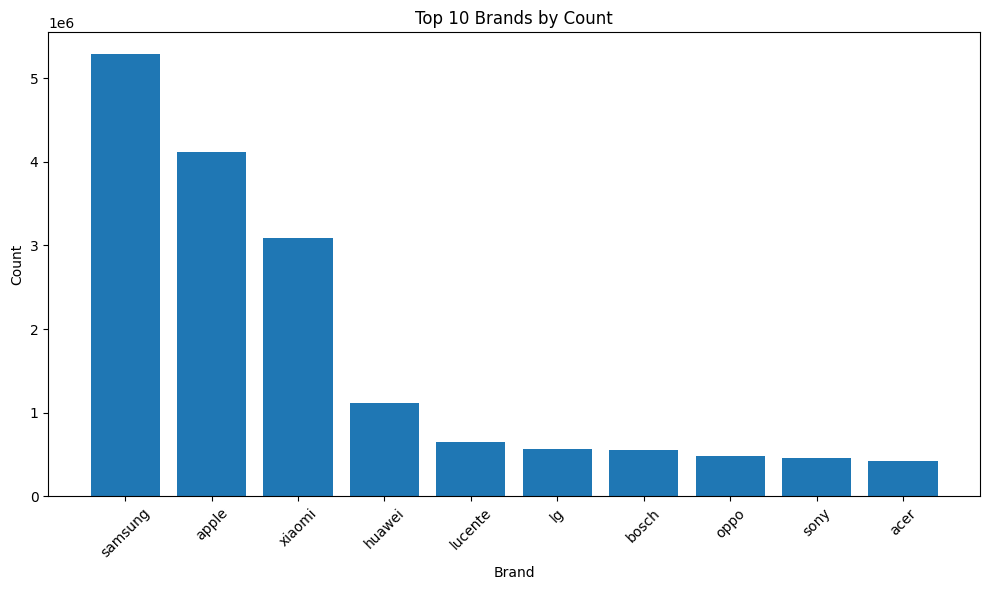

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 0.4868
}
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 21
  Total tokens: ~1,490
  Breakdown: System=124, User=97, Assistant=306, Tool=962
CPU times: user 459 ms, sys: 114 ms, total: 573 ms
Wall time: 6.85 s


In [24]:
%%time
ask("plot the count of the top 10 brand in one bar chart")

💬 You: plot the mean price of the top 10 brand in one bar chart

🤖 Agent:
USER PROMPT: plot the mean price of the top 10 brand in one bar chart


  Calling: execute_python_code{"code":"top_brands = df['brand'].value_counts().head(10)\nmean_prices = df[df['brand'].isin(top_brands.index)]['price'].groupby(df['brand']).mean()\nplt.figure(figsize=(10, 6))\nplt.bar(mean_prices.index, mean_prices.values)\nplt.xlabel('Brand')\nplt.ylabel('Mean Price')\nplt.title('Mean Price of Top 10 Brands')\nplt.xticks(rotation=45)\nplt.tight_layout()\nplt.show()","use_gpu":true}
  -> Calling tool: execute_python_code
    use_gpu: True
    code:
      top_brands = df['brand'].value_counts().head(10)
      mean_prices = df[df['brand'].isin(top_brands.index)]['price'].groupby(df['brand']).mean()
      plt.figure(figsize=(10, 6))
      plt.bar(mean_prices.index, mean_prices.values)
      plt.xlabel('Brand')
      plt.ylabel('Mean Price')
      plt.title('Mean Price of Top 10 Brands')
      plt.xticks(rotation=

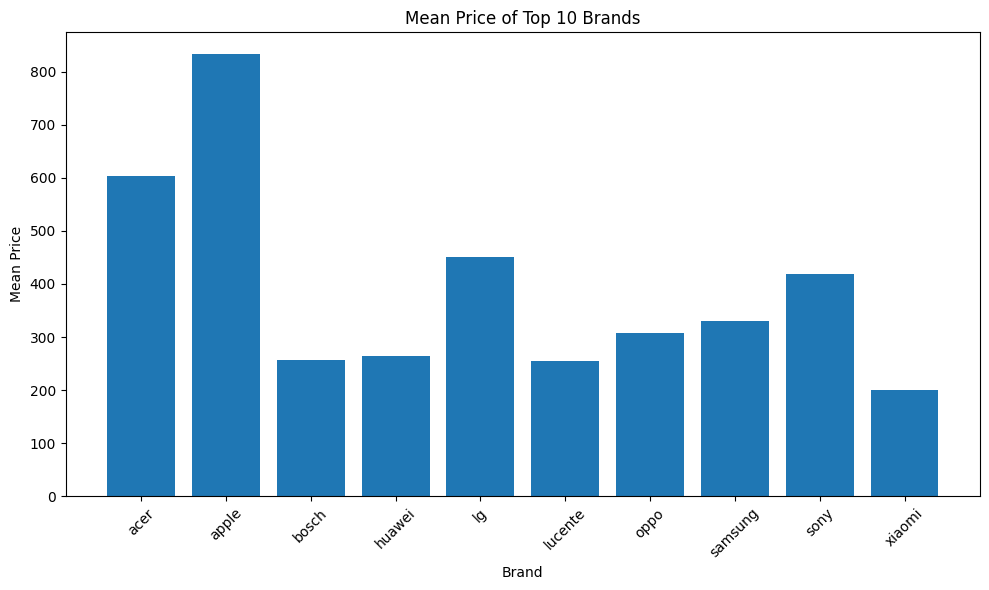

{
  "success": true,
  "mode": "gpu_accelerated",
  "execution_time_seconds": 2.5373
}
No output from execution, exiting
[Agent Response]

📊 Context Usage:
  Messages: 23
  Total tokens: ~1,636
  Breakdown: System=124, User=111, Assistant=438, Tool=962
CPU times: user 1.95 s, sys: 1 s, total: 2.95 s
Wall time: 10.8 s


In [25]:
%%time
ask("plot the mean price of the top 10 brand in one bar chart")

## What You Just Learned

You've built a GPU-accelerated data science agent!

### Key Points

**GPU Acceleration** - Just 2 lines:
```python
import cudf.pandas
cudf.pandas.install()
```

**Natural Language Analysis**
- Ask questions in plain English
- Agent writes and executes pandas code automatically
- Variables persist across conversations

**Performance** - GPU speeds up operations on large datasets with no code changes

### Try It Yourself

1. Duplicate any chat cell above
2. Ask your own questions
3. Load your own CSV files
4. Check `agent.py` and `tools.py` to see the implementation

**Remember:** GPU acceleration + LLM function calling = powerful interactive data analysis

In [26]:
import psutil
import os
import signal

def kill_child_processes(parent_pid=None, sig=signal.SIGTERM):
    if parent_pid is None:
        parent_pid = os.getpid()
    try:
        parent = psutil.Process(parent_pid)
    except psutil.NoSuchProcess:
        return
    for child in parent.children(recursive=True):
        try:
            child.send_signal(sig)
        except Exception:
            pass

# Call this at the end of your notebook
kill_child_processes()
import atexit

atexit.register(kill_child_processes)

<function __main__.kill_child_processes(parent_pid=None, sig=<Signals.SIGTERM: 15>)>